# 画图：观察攻击模型对噪声的适应性

In [2]:
import pandas as pd
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("stupidtree/[EXP]BiSR_diff_noise_dxp")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })


In [3]:
filtered = []

for summary, config, name in zip(summary_list, config_list, name_list):
    if config['dataset'] == 'piqa':
        filtered.append((summary, config, name))

In [4]:
sfl_noise_scales = set()

for summary, config, name in filtered:
    sfl_noise_scales.add(config['noise_scale'])

In [5]:
result_map = {}
for sfl_noise_scale in sfl_noise_scales:
    if sfl_noise_scale == 0.05:
        continue
    attack_performs = {}
    ppl_avg = 0
    tag_avg = 0
    case_num = 0
    for summary, config, name in filtered:
        if config['noise_scale'] == sfl_noise_scale:
            model_name = config['attacker_model']
            if model_name == 'gru':
                model_name = 'GRU'
            elif model_name == 'moe':
                model_name = 'NaMoE'
            attack_performs[f'SDRP-only({model_name})'] = summary['client0_DRA_b2tr_rgLf_avg']
            attack_performs[f'BiSR({model_name})'] = summary['client0_DLG_rgL_f_avg']
            ppl_avg += summary['client0_test-ppl']
            tag_avg += summary['client0_DLG_raw_rgLf_avg']
            case_num += 1
    attack_performs['PPL'] = ppl_avg / case_num
    attack_performs['TAG'] = tag_avg / case_num
    result_map[sfl_noise_scale] = attack_performs


result_map

{0.4: {'SDRP-only(NaMoE)': 0.9341203769886958,
  'BiSR(NaMoE)': 0.9562309936684008,
  'SDRP-only(GRU)': 0.9208691540006496,
  'BiSR(GRU)': 0.957274259039253,
  'PPL': 27.42047119140625,
  'TAG': 0.6357574456665904},
 0.35: {'SDRP-only(GRU)': 0.9186548199912828,
  'BiSR(GRU)': 0.9552134207714864,
  'SDRP-only(NaMoE)': 0.931016074336508,
  'BiSR(NaMoE)': 0.953688543360348,
  'PPL': 26.752375602722168,
  'TAG': 0.6344714256854148},
 0.3: {'SDRP-only(GRU)': 0.907619819825039,
  'BiSR(GRU)': 0.9505707416278162,
  'SDRP-only(NaMoE)': 0.925106851920015,
  'BiSR(NaMoE)': 0.951025940387782,
  'PPL': 26.05545425415039,
  'TAG': 0.6307888174808163},
 0.25: {'SDRP-only(GRU)': 0.8295039966525024,
  'BiSR(GRU)': 0.9083927126359108,
  'SDRP-only(NaMoE)': 0.8969522006394846,
  'BiSR(NaMoE)': 0.9253827048282968,
  'PPL': 25.845858573913574,
  'TAG': 0.614390175674453},
 0.2: {'SDRP-only(GRU)': 0.6144549170643762,
  'BiSR(GRU)': 0.8227384814032175,
  'SDRP-only(NaMoE)': 0.80178151994928,
  'BiSR(NaMoE)'

In [6]:
# rearrange the result

all_data = {}
for key in list(result_map.values())[0].keys():
    all_data[key] = {}
    for sfl_noise_scale, attack_performs in result_map.items():
        all_data[key][sfl_noise_scale] = attack_performs[key]


/tmp/ipykernel_372821/286619934.py:91: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles2, labels2 = ax2.get_legend_handles_labels()


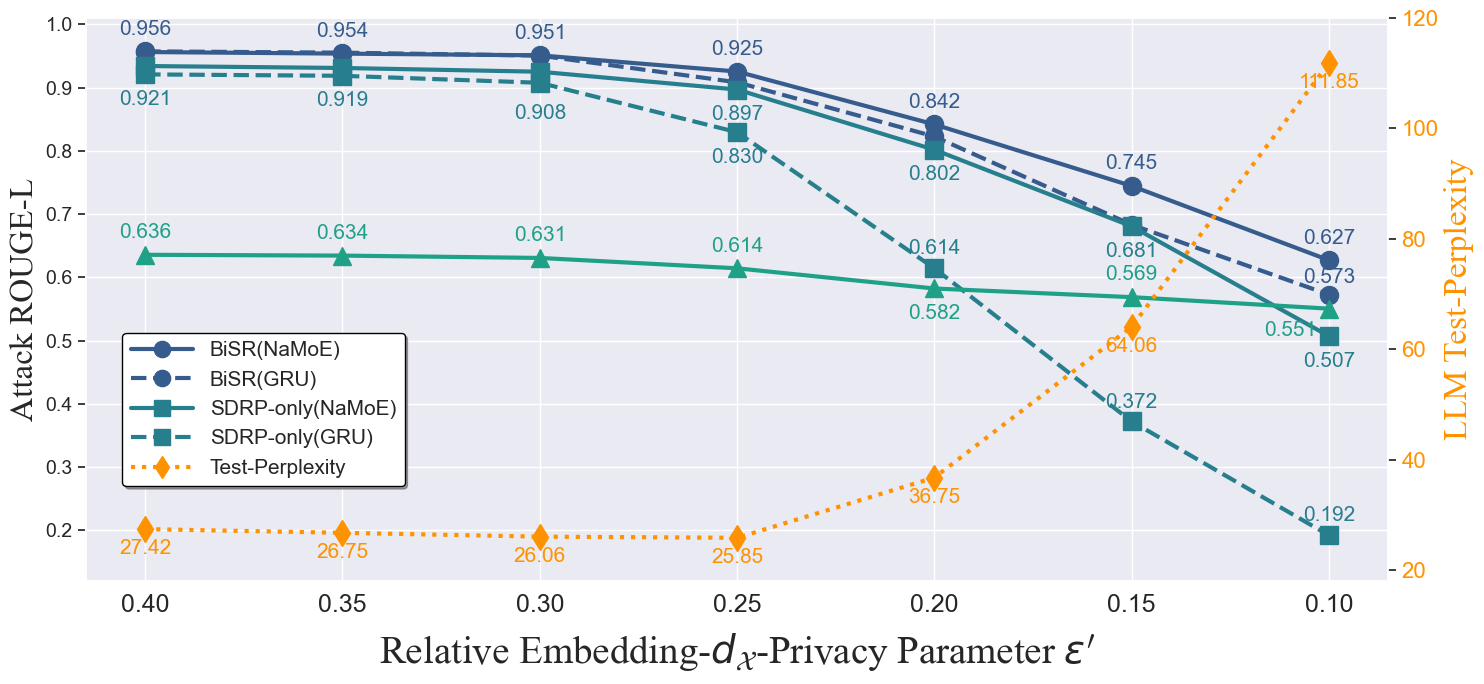

In [41]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

# create line figure with two y axis, one for ppl and one for rouge
fig, ax1 = plt.subplots(figsize=(15, 7))
# plot rouge

ax2 = ax1.twinx()
all_data = dict(sorted(all_data.items(), key=lambda x: x[0]))

atk_colors = sns.color_palette("viridis", 6)
color_ppl = sns.color_palette("autumn", 6)[3]
for key, attack_performs in all_data.items():
    ns = attack_performs.keys()
    ps = [attack_performs[n] for n in ns]
    if key == 'PPL':
        ax2.plot(ns, ps, markersize=13, color=color_ppl, marker='d', linestyle=':', label='Test-Perplexity',linewidth=3)
        # plit text on top of the line
        for i, txt in enumerate(ps):
            ax2.annotate(f'{txt:.2f}', (list(ns)[i], list(ps)[i]), textcoords="offset points", xytext=(0, -18),
                         ha='center', fontsize=15, color=color_ppl, label='Test-Perplexity')
    else:
        marker = 'o'
        color = atk_colors[1]
        if 'SDRP' in key:
            marker = 's'
            color = atk_colors[2]
        elif 'TAG' in key:
            marker = '^'
            color = atk_colors[3]
        if 'GRU' in key:
            line_style = '--'
        else:
            line_style = '-'
        ax1.plot(ns, ps, marker=marker, markersize=13, label=key, color=color, linestyle=line_style, linewidth=3)
        if key == 'BiSR(NaMoE)':
            # plot text on top of the line
            for i, txt in enumerate(ps):
                ax1.annotate(f'{txt:.3f}', (list(ns)[i], list(ps)[i]), textcoords="offset points", xytext=(0, 12),
                             ha='center', fontsize=15, color=color)
        if key == 'BiSR(GRU)':
            # plot text on top of the line
            for i, txt in enumerate(ps):
                if list(ns)[i] != 0.1:
                    continue
                ax1.annotate(f'{txt:.3f}', (list(ns)[i], list(ps)[i]), textcoords="offset points", xytext=(0, 8),
                             ha='center', fontsize=15, color=color)
        if key == 'TAG':
            for i, txt in enumerate(ps):
                pos = 12
                pos_x = 0
                if i == 4:
                    pos = -22
                if list(ns)[i] == 0.1:
                    pos_x = -28
                    pos = -20
                ax1.annotate(f'{txt:.3f}', (list(ns)[i], list(ps)[i]), textcoords="offset points", xytext=(pos_x, pos),
                             ha='center', fontsize=15, color=color)
        if key == 'SDRP-only(GRU)':
            # plot text on top of the line
            for i, txt in enumerate(ps):
                pos = -22 if i < 4 else 10
                pos_x = 0
                if i == 2:
                    pos = -26
                ax1.annotate(f'{txt:.3f}', (list(ns)[i], list(ps)[i]), textcoords="offset points", xytext=(pos_x, pos),
                             ha='center', fontsize=15, color=color)
        if key == 'SDRP-only(NaMoE)':
            # plot text on top of the line
            for i, txt in enumerate(ps):
                if i <= 2:
                    continue
                pos = -22
                ax1.annotate(f'{txt:.3f}', (list(ns)[i], list(ps)[i]), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=15, color=color)

ax1.tick_params(axis='y', labelsize=14)
ax1.set_ylim(0.12, 1.01)
ax1.set_ylabel('Attack ROUGE-L', fontsize=24,fontname="Times New Roman")
ax2.set_ylabel('LLM Test-Perplexity', fontsize=24, fontname="Times New Roman", color=color_ppl)
ax2.tick_params(axis='y', labelcolor=color_ppl, labelsize=16)
ax1.set_xlabel('Relative Embedding-$d_{\mathcal{X}}$-Privacy Parameter $\epsilon\'$', fontsize=28, fontname="Times New Roman", labelpad=10)
ax1.tick_params(axis='x', labelsize=18)

ax2.set_ylim(18, 120)
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[3], handles[2]]
labels = [labels[1], labels[0], labels[3], labels[2]]
handles.extend(handles2)
labels.extend(labels2)
plt.legend(handles, labels, fontsize=15, ncol=1, loc='lower left', bbox_to_anchor=(0.02, 0.15),
           markerscale=0.9, handlelength=3.0, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor='black',
           facecolor='white')
ax2.yaxis.grid(False)
# reverse the x axis
plt.gca().invert_xaxis()
# save the figure
plt.tight_layout()
plt.savefig('/root/autodl-tmp/sfl/exp_data/diff_noise_dxp.pdf')